In [14]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble, QuantumRegister, ClassicalRegister
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer import QasmSimulator
from qiskit.visualization import plot_histogram
import qiskit.quantum_info as qi
from qiskit.tools.jupyter import *
from qiskit.visualization import *


In [15]:
def egcd(a, b):
    if a == 0:
        return (b, 0, 1)
    else:
        g, y, x = egcd(b % a, a)
        return (g, x - (b // a) * y, y)

def modinv(a, m):
    g, x, y = egcd(a, m)
    if g != 1:
        raise Exception('modular inverse does not exist')
    else:
        return x % m

print('inverse modulus test: ',modinv(38,97))

inverse modulus test:  23


In [16]:
def build_qft_circuit(n_bits,input_qubits):
    circuit_qft = QuantumCircuit(n_bits, n_bits)
    for i in range(len(input_qubits)):
        print(i)
        if(input_qubits[i] == 1):
            circuit_qft.x(len(input_qubits)-1-i)
    circuit_qft.barrier()
    #print('inside construction circuit')
    for i in range(n_bits-1,0,-1):
        circuit_qft.h(i)
        for j in range(2,n_bits+1):
            #print(i,j,i-j+1)
            circuit_qft.cp((2*np.pi)/(2**j),i-j+1,i)
            if(i-j+1 == 0):
                break
        #print('end for j')
    circuit_qft.h(0)
    circuit_qft.barrier()
    #SWAP operation
    for i in range(0,int(n_bits/2)):
        circuit_qft.swap(i,n_bits-1-i)
    circuit_qft.barrier()
    return circuit_qft

In [17]:
def build_inv_qft_circuit(n_bits):
    circuit_qft = QuantumCircuit(n_bits, n_bits)
    circuit_qft.barrier()
    #SWAP operation
    for i in range(0,int(n_bits/2)):
        circuit_qft.swap(i,n_bits-1-i)
    circuit_qft.barrier()
    #print('inside construction circuit')
    circuit_qft.h(0)
    for i in range(1, n_bits):
        for j in range(2,i+2):
            #print(i,j,i-j+1)
            circuit_qft.cp((-2*np.pi)/(2**j),i-j+1,i)
            if(i-j+1 == 0):
                break
        #print('end for j')
        circuit_qft.h(i)
    circuit_qft.barrier()
    return circuit_qft

In [18]:
def build_inv_qft_circuit_2(circuit_qft, n_bits):
    #circuit_qft = QuantumCircuit(n_bits, n_bits)
    circuit_qft.barrier()
    #SWAP operation
#     for i in range(0,int(n_bits/2)):
#         circuit_qft.swap(i,n_bits-1-i)
#     circuit_qft.barrier()
    #print('inside construction circuit')
    circuit_qft.h(0)
    for i in range(1, n_bits):
        for j in range(2,i+2):
            #print(i,j,i-j+1)
            circuit_qft.cp((-2*np.pi)/(2**j),i-j+1,i)
            if(i-j+1 == 0):
                break
        #print('end for j')
        circuit_qft.h(i)
    circuit_qft.barrier()
    return circuit_qft

In [19]:
def _7mod15(power,control,circuit): 
    print(power,control)
    circuit.barrier()
    for i in range(2**power):
        circuit.cswap(control,n_bits,n_bits + 1)
        circuit.cswap(control,n_bits + 1,n_bits + 2)
        circuit.cswap(control,n_bits + 2,n_bits + 3)
        circuit.cx(control,n_bits)
        circuit.cx(control,n_bits + 1)
        circuit.cx(control,n_bits + 2)
        circuit.cx(control,n_bits + 3)
        circuit.barrier()
    circuit.barrier()
    return circuit

In [101]:
def carry():
    carry = QuantumCircuit(4)
    carry.ccx(1,2,3)
    carry.cx(1,2)
    carry.ccx(0,2,3)
    carry.to_gate()
    carry.name = "CARRY"
    return carry

def carry_n():
    carry_n = carry()
    carry_n = carry_n.inverse()
#     Se decide reemplazar por la funcion interna de reversion de qiskit
#     carry_n = QuantumCircuit(4)
#     carry_n.ccx(0,2,3)
#     carry_n.cx(1,2)
#     carry_n.ccx(1,2,3)
    carry_n.to_gate()
    carry_n.name = "CARRY_N"
    return carry_n

def SUM():
    SUM = QuantumCircuit(3)
    SUM.cx(1,2)
    SUM.cx(0,2)
    SUM.to_gate()
    SUM.name = "SUM"
    return SUM

def SUM_n():
    SUM_n = SUM()
    SUM_n = SUM_n.inverse()
#     SUM_n = QuantumCircuit(3)
#     SUM_n.cx(0,2)
#     SUM_n.cx(1,2)
    SUM_n.to_gate()
    SUM_n.name = "SUM_n"
    return SUM_n

def adder(a,b,carry_g):
    adder = QuantumCircuit(a, b, carry_g)
    n_bits = int((adder.num_qubits - 1) / 3)
    for i in range(n_bits-1):
        adder.append(carry(),
                     [carry_g[i]] + 
                     [a[i]] + 
                     [b[i]] + 
                     [carry_g[i+1]])
    adder.append(carry(),
                     [carry_g[n_bits-1]] + 
                     [a[n_bits-1]] + 
                     [b[n_bits-1]] + 
                     [b[n_bits]])
    adder.cx(a[n_bits-1],b[n_bits-1])
    for i in range(n_bits-1,0,-1):
        adder.append(SUM(),
                    [carry_g[i]] + 
                    [a[i]] +
                    [b[i]])
        adder.append(carry_n(),
                    [carry_g[i-1]] + 
                    [a[i-1]] + 
                    [b[i-1]] + 
                    [carry_g[i]])
    adder.append(SUM(),
                    [carry_g[0]] + 
                    [a[0]] +
                    [b[0]])
    adder.name = "adder"
    return adder

def substractor(a,b,carry_g):
    sub = QuantumCircuit(a, b, carry_g)
    sub.append(adder(a,b,carry_g), 
                 [a[i] for i in range(len(a))] + 
                 [b[i] for i in range(len(b))] + 
                 [carry_g[i] for i in range(len(carry_g))])
    sub = sub.inverse()
#     n_bits = int((sub.num_qubits - 1) / 3)
#     for i in range(n_bits-1):
#         sub.append(SUM_n(), # SUM_n (b-a)
#                 [carry_g[i]] + 
#                 [a[i]] +
#                 [b[i]])
#         sub.append(carry(),
#                 [carry_g[i]] + 
#                 [a[i]] + 
#                 [b[i]] + 
#                 [carry_g[i+1]])
#     sub.append(SUM_n(), # SUM_n (b-a)
#             [carry_g[n_bits-1]] + 
#             [a[n_bits-1]] +
#             [b[n_bits-1]])
#     sub.cx(a[n_bits-1],b[n_bits-1])
#     sub.append(carry_n(), # carry_n (b-a)
#                 [carry_g[n_bits-1]] + 
#                 [a[n_bits-1]] + 
#                 [b[n_bits-1]] + 
#                 [b[n_bits]])
#     for i in range(n_bits-2,-1,-1):
#         sub.append(carry_n(), # carry_n (b-a)
#             [carry_g[i]] + 
#             [a[i]] + 
#             [b[i]] + 
#             [carry_g[i+1]])
    sub.name = "sub"
    return sub

def cont_swap():
    c_swap = QuantumCircuit(3)
    c_swap.cx(2,1)
    c_swap.ccx(0,1,2)
    c_swap.cx(2,1)
    c_swap.name = "C_SWAP"
    return c_swap

def modsum(a,b,N,carry_g,t,N_value):
    modsum = QuantumCircuit(a,b,N,carry_g,t)
    n_bits = int((modsum.num_qubits - 2) / 4)
    modsum.append(adder(a,b,carry_g), 
                 [a[i] for i in range(len(a))] + 
                 [b[i] for i in range(len(b))] + 
                 [carry_g[i] for i in range(len(carry_g))])
    modsum.append(substractor(N,b,carry_g), 
                 [N[i] for i in range(len(N))] +  
                 [b[i] for i in range(len(b))] + 
                 [carry_g[i] for i in range(len(carry_g))])
    modsum.x(b[len(b)-1])
    modsum.cx(b[len(b)-1],t[0])
    modsum.x(b[len(b)-1])
#     # controlled swap between 0 and N
#     for i in range(len(N)):
#         modsum.append(cont_swap(),
#                      [t[0]] + 
#                      [cero[i]] + 
#                      [N[i]])
# #         modsum.cswap(t[0],cero[i],N[i])
    N_i = [int(k) for k in list('{0:0b}'.format(N_value))]
    N_i = N_i[::-1]
    for i in range(len(N_i)):
        if(N_i[i] == 1):
            modsum.cx(t[0],N[i])
    modsum.append(adder(N,b,carry_g), 
                 [N[i] for i in range(len(N))] + 
                 [b[i] for i in range(len(b))] + 
                 [carry_g[i] for i in range(len(carry_g))])
#     for i in range(len(N)):
#         modsum.append(cont_swap(),
#                      [t[0]] + 
#                      [cero[i]] + 
#                      [N[i]])
# #         modsum.cswap(t[0],cero[i],N[i])
    for i in range(len(N_i)):
        if(N_i[i] == 1):
            modsum.cx(t[0],N[i])
    modsum.append(substractor(a,b,carry_g), 
                 [a[i] for i in range(len(a))] +  
                 [b[i] for i in range(len(b))] + 
                 [carry_g[i] for i in range(len(carry_g))])
#     modsum.x(b[len(b)-1])
    modsum.cx(b[len(b)-1],t[0])
#     modsum.x(b[len(b)-1])
    modsum.append(adder(a,b,carry_g), 
                 [a[i] for i in range(len(a))] + 
                 [b[i] for i in range(len(b))] + 
                 [carry_g[i] for i in range(len(carry_g))])
    modsum.name = "modsum"
    return modsum 

def controlled_multiplication(a,b,N,x,c,carry_g,t,a_value,N_value):
    cm = QuantumCircuit(a,b,N,x,c,carry_g,t)
    n_bits = int((cm.num_qubits - 4) / 5)
    for i in range(len(x)):
        b_i = a_value*(2**i)%N_value
        a_i = [int(k) for k in list('{0:0b}'.format(b_i))]
        if(len(a_i) <= n_bits):
            long_a = len(a_i)
        else:
            long_a = n_bits
        a_i = a_i[::-1]
        for j in range(long_a):
            if(a_i[j] == 1):
                cm.ccx(c[0],x[i],a[j])
        cm.append(modsum(a,b,N,carry_g,t,N_value), 
                 [a[i] for i in range(len(a))] + 
                 [b[i] for i in range(len(b))] + 
                 [N[i] for i in range(len(N))] +
                 [carry_g[i] for i in range(len(carry_g))] + 
                 [t])
        for j in range(long_a):
            if(a_i[j] == 1):
                cm.ccx(c[0],x[i],a[j])
    cm.x(c[0])
    for i in range(len(x)):
        cm.ccx(c[0],x[i],b[i])
    cm.x(c[0])
    cm.name = "cont_mult"
    return cm

def rev_controlled_multiplication(a,b,N,x,c,carry_g,t,a_value,N_value):
    rev_cm = QuantumCircuit(a,b,N,x,c,carry_g,t)
    rev_cm.append(controlled_multiplication(a,b,N,x,c,carry_g,t,a_value,N_value),
                 [a[i] for i in range(len(a))] +
                 [b[i] for i in range(len(b))] +
                 [N[i] for i in range(len(N))] +
                 [x[i] for i in range(len(x))] +
                 [c[0]] + 
                 [carry_g[i] for i in range(len(carry_g))] +
                 [t[0]])
    rev_cm = rev_cm.inverse()
    return rev_cm

def exponential_mod(a,b,N,x,carry_g,t,exp,a_value,N_value):
    exp_mod = QuantumCircuit(a,b,N,x,carry_g,t,exp)
#     n_bits = int((exp_mod.num_qubits - 5) / 5)
    for i in range(len(exp)):
        a_value1 = a_value**(2**i)
#         a_value1 = a_value1**i
        a_value1 = a_value1%N_value
        a_value2 = modinv(a_value, N_value)
        # a_value2 = pow(a_value, -1, N_value) # python 3.8
        a_value2 = a_value2**(2**i)
        a_value2 = a_value2%N_value
        # print(a_value1, a_value2)
        if(i%2 == 0):
            exp_mod.append(controlled_multiplication(a,b,N,x,QuantumRegister(1,'aux'),carry_g,t,a_value1,N_value),
                     [a[i] for i in range(len(a))] +
                     [b[i] for i in range(len(b))] +
                     [N[i] for i in range(len(N))] +
                     [x[i] for i in range(len(x))] +
                     [exp[i]] + 
                     [carry_g[i] for i in range(len(carry_g))] +
                     [t[0]])
            exp_mod.append(rev_controlled_multiplication(a,x,N,b,QuantumRegister(1,'aux'),carry_g,t,a_value2,N_value),
                     [a[i] for i in range(len(a))] +
                     [x[i] for i in range(len(x))] +
                     [N[i] for i in range(len(N))] +
                     [b[i] for i in range(len(b))] +
                     [exp[i]] + 
                     [carry_g[i] for i in range(len(carry_g))] +
                     [t[0]])
        else:
            exp_mod.append(controlled_multiplication(a,x,N,b,QuantumRegister(1,'aux'),carry_g,t,a_value1,N_value),
                     [a[i] for i in range(len(a))] +
                     [x[i] for i in range(len(x))] +
                     [N[i] for i in range(len(N))] +
                     [b[i] for i in range(len(b))] +
                     [exp[i]] + 
                     [carry_g[i] for i in range(len(carry_g))] +
                     [t[0]])
            exp_mod.append(rev_controlled_multiplication(a,b,N,x,QuantumRegister(1,'aux'),carry_g,t,a_value2,N_value),
                     [a[i] for i in range(len(a))] +
                     [b[i] for i in range(len(b))] +
                     [N[i] for i in range(len(N))] +
                     [x[i] for i in range(len(x))] +
                     [exp[i]] + 
                     [carry_g[i] for i in range(len(carry_g))] +
                     [t[0]])
    return exp_mod

def U_exp_mod(a,b,N,x,carry_g,t,control,a_value,N_value,u_exp):
    u_exp_mod = QuantumCircuit(a,b,N,x,carry_g,t,control)
    for i in range(u_exp):
        u_exp_mod.append(exponential_mod(a,b,N,x,carry_g,t,control,a_value,N_value),
                        [a[i] for i in range(len(a))] +
                        [b[i] for i in range(len(b))] +
                        [N[i] for i in range(len(N))] +
                        [x[i] for i in range(len(x))] +
                        [carry_g[i] for i in range(len(carry_g))] +
                        [t[0]] + 
                        [control[0]])
        for j in range(len(b)):
            u_exp_mod.swap(b[j],x[j])
#             u_exp_mod.cswap(control[0],b[j],x[j])
    return u_exp_mod

def exponential_mod_eff(a,b,N,x,carry_g,t,control,a_value,N_value,exp):
    exp_mod_eff = QuantumCircuit(a,b,N,x,carry_g,t,control)
#     n_bits = int((exp_mod.num_qubits - 5) / 5)

    a_value1 = a_value**(2**exp)
#         a_value1 = a_value1**i
    a_value1 = a_value1%N_value
    a_value2 = modinv(a_value, N_value)
    a_value2 = a_value2**(2**exp)
    a_value2 = a_value2%N_value
    
    exp_mod_eff.append(controlled_multiplication(a,b,N,x,control,carry_g,t,a_value1,N_value),
             [a[i] for i in range(len(a))] +
             [b[i] for i in range(len(b))] +
             [N[i] for i in range(len(N))] +
             [x[i] for i in range(len(x))] +
             [control[0]] + 
             [carry_g[i] for i in range(len(carry_g))] +
             [t[0]])
    exp_mod_eff.append(rev_controlled_multiplication(a,x,N,b,control,carry_g,t,a_value2,N_value),
             [a[i] for i in range(len(a))] +
             [x[i] for i in range(len(x))] +
             [N[i] for i in range(len(N))] +
             [b[i] for i in range(len(b))] +
             [control[0]] + 
             [carry_g[i] for i in range(len(carry_g))] +
             [t[0]])
    for j in range(len(b)):
            exp_mod_eff.swap(b[j],x[j])
    return exp_mod_eff

def U_exp_mod_eff(a,b,N,x,carry_g,t,control,a_value,N_value,u_exp):
    u_exp_mod_eff = QuantumCircuit(a,b,N,x,carry_g,t,control)
    u_exp_binary = [int(k) for k in list('{0:0b}'.format(u_exp))]
    u_exp_binary = u_exp_binary[::-1]
    for i in range(len(u_exp_binary)):
        if(u_exp_binary[i] == 1):
            u_exp_mod_eff.append(exponential_mod_eff(a,b,N,x,carry_g,t,control,a_value,N_value,i),
                        [a[i] for i in range(len(a))] +
                        [b[i] for i in range(len(b))] +
                        [N[i] for i in range(len(N))] +
                        [x[i] for i in range(len(x))] +
                        [carry_g[i] for i in range(len(carry_g))] +
                        [t[0]] + 
                        [control[0]])
    u_exp_mod_eff.name = "u_"+str(u_exp)
    return u_exp_mod_eff
    

In [21]:
y = modinv(16, 15)
print(y)
!python --version

1
Python 2.7.16


In [ ]:
a = QuantumRegister(4,'a')
b = QuantumRegister(5,'b')
carr = QuantumRegister(4,'carry_g')
output = ClassicalRegister(13,'output')

adder_test = QuantumCircuit(a,b,carr,output)

adder_test.x(2)
adder_test.x(3)

adder_test.x(5)
adder_test.x(6)
adder_test.x(7)
adder_test.x(8)

adder_test.append(adder(a,b,carr), 
                 [0,1,2,3,4,5,6,7,8,9,10,11,12])

adder_test.decompose().draw()

In [ ]:
for i in range(13):
    adder_test.measure(i,i)

# test_full_adder.measure(7, 3)
adder_test.draw()

In [ ]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(adder_test, qasm_sim)
qobj = assemble(t_qc)
job = qasm_sim.run(qobj)
status = job.status()
print(status)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

In [ ]:
simulator = AerSimulator(method='matrix_product_state')
tcirc = transpile(adder_test, simulator)
result = simulator.run(tcirc).result()
counts = result.get_counts(0)
plot_histogram(counts)

In [ ]:
a = QuantumRegister(4,'a')
b = QuantumRegister(5,'b')
carr = QuantumRegister(4,'carry_g')
output = ClassicalRegister(13,'output')

sub_test = QuantumCircuit(a,b,carr,output)


sub_test.x(2)
# sub_test.x(1)


sub_test.x(4)
# sub_test.x(6)
# sub_test.x(7)
# sub_test.x(8)

sub_test.append(substractor(a,b,carr), 
                 [0,1,2,3,4,5,6,7,8,9,10,11,12])

sub_test.decompose().draw()

In [ ]:
for i in range(13):
    sub_test.measure(i,i)

# test_full_adder.measure(7, 3)
sub_test.draw()

In [ ]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(sub_test, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [ ]:
simulator = AerSimulator(method='matrix_product_state')
tcirc = transpile(sub_test, simulator)
result = simulator.run(tcirc).result()
counts = result.get_counts(0)
plot_histogram(counts)

In [ ]:
a = QuantumRegister(4,'a')
b = QuantumRegister(5,'b')
N = QuantumRegister(4,'n_N')
t = QuantumRegister(1,'t')
cero = QuantumRegister(4,'cero')
carr = QuantumRegister(4,'carry_g')
output = ClassicalRegister(18,'output')

modsum_test = QuantumCircuit(a,b,N,carr,t,output)


modsum_test.x(1)
modsum_test.x(2)

modsum_test.x(4)
modsum_test.x(5)
# modsum_test.x(6)
modsum_test.x(7)

modsum_test.x(12)
N_value = 8
modsum_test.append(modsum(a,b,N,carr,t,N_value), 
                 [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

modsum_test.decompose().draw()

In [ ]:
for i in range(17):
    modsum_test.measure(i,i)

# test_full_adder.measure(7, 3)
modsum_test.draw()

In [ ]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(modsum_test, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [ ]:
simulator = AerSimulator(method='matrix_product_state')
tcirc = transpile(modsum_test, simulator)
result = simulator.run(tcirc).result()
counts = result.get_counts(0)
plot_histogram(counts)

In [ ]:
simulator = AerSimulator(method='extended_stabilizer')
tcirc = transpile(modsum_test, simulator)
result = simulator.run(tcirc).result()
counts = result.get_counts(0)
plot_histogram(counts)

In [ ]:
print(4 + 5 + 4 + 4 + 3 + 4 + 4 + 4)

In [ ]:
a = QuantumRegister(4,'a')
b = QuantumRegister(5,'b')
N = QuantumRegister(4,'n_N')
x = QuantumRegister(5,'n_x')
t = QuantumRegister(1,'t')
c = QuantumRegister(1,'c')
aux = QuantumRegister(1,'aux')
cero = QuantumRegister(4,'cero')
cero_aux = QuantumRegister(4,'cero_aux')
carr = QuantumRegister(4,'carry_g')
output = ClassicalRegister(24,'output')

cm_test = QuantumCircuit(a,b,N,x,c,carr,t,output)
a_value = 6
N_value = 7
# cm_test.x(1)

cm_test.x(9)
cm_test.x(10)
cm_test.x(11)
# cm_test.x(12)

cm_test.x(18)

cm_test.x(13)
cm_test.x(14)
cm_test.x(15)
cm_test.x(16)


cm_test.append(controlled_multiplication(a,b,N,x,c,carr,t,a_value,N_value), 
                 [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

cm_test.decompose().decompose().draw()

In [ ]:
for i in range(24):
    cm_test.measure(i,i)

# test_full_adder.measure(7, 3)
cm_test.draw()

In [ ]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(cm_test, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj,shots=10).result()
counts = results.get_counts()
plot_histogram(counts)

In [ ]:
a = QuantumRegister(4,'a')
b = QuantumRegister(5,'b')
N = QuantumRegister(4,'n_N')
x = QuantumRegister(5,'n_x')
t = QuantumRegister(1,'t')
c = QuantumRegister(1,'c')
aux = QuantumRegister(1,'aux')
cero = QuantumRegister(4,'cero')
cero_aux = QuantumRegister(4,'cero_aux')
carr = QuantumRegister(4,'carry_g')
output = ClassicalRegister(24,'output')

rcm_test = QuantumCircuit(a,b,N,x,c,carr,t,output)
a_value = 6
N_value = 7

rcm_test.x(5)
rcm_test.x(6)
rcm_test.x(9)
rcm_test.x(10)
rcm_test.x(11)
rcm_test.x(13)
rcm_test.x(14)
rcm_test.x(15)
rcm_test.x(16)
rcm_test.x(18)

rcm_test.append(rev_controlled_multiplication(a,b,N,x,c,carr,t,a_value,N_value), 
                 [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

rcm_test.decompose().decompose().draw()

In [ ]:
for i in range(24):
    rcm_test.measure(i,i)

# test_full_adder.measure(7, 3)
rcm_test.draw()

In [ ]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(rcm_test, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj,shots=10).result()
counts = results.get_counts()
plot_histogram(counts)

In [ ]:
a = QuantumRegister(4,'a')
b = QuantumRegister(5,'b')
N = QuantumRegister(4,'n_N')
x = QuantumRegister(5,'n_x')
t = QuantumRegister(1,'t')
c = QuantumRegister(1,'c')
aux = QuantumRegister(1,'aux')
cero = QuantumRegister(4,'cero')
exp = QuantumRegister(3,'exp')
cero_aux = QuantumRegister(4,'cero_aux')
carr = QuantumRegister(4,'carry_g')
output = ClassicalRegister(26,'output')
# exponential_mod(a,b,N,x,carry_g,t,exp,a_value,N_value)
exp_test = QuantumCircuit(a,b,N,x,carr,t,exp,output)
a_value = 7
N_value = 15

exp_test.x(9)
exp_test.x(10)
exp_test.x(11)
exp_test.x(12)

exp_test.x(13)


exp_test.x(23)
# exp_test.x(24)
exp_test.x(25)
# exp_test.x(25)

exp_test.append(exponential_mod(a,b,N,x,carr,t,exp,a_value,N_value), 
                 [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])

exp_test.decompose().draw()

In [ ]:
for i in range(26):
    exp_test.measure(i,i)

# test_full_adder.measure(7, 3)
exp_test.draw()

In [ ]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(exp_test, qasm_sim)
qobj = assemble(t_qc)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [46]:
a = QuantumRegister(4,'a')
b = QuantumRegister(5,'b')
N = QuantumRegister(4,'n_N')
x = QuantumRegister(5,'n_x')
t = QuantumRegister(1,'t')
control = QuantumRegister(1,'control')
carr = QuantumRegister(4,'carry_g')
output = ClassicalRegister(24,'output')
# exponential_mod(a,b,N,x,carry_g,t,exp,a_value,N_value)
u_exp_test = QuantumCircuit(a,b,N,x,carr,t,control,output)

a_value = 7
N_value = 15
u_exp = 8

u_exp_test.x(9)
u_exp_test.x(10)
u_exp_test.x(11)
u_exp_test.x(12)

u_exp_test.x(13)


u_exp_test.x(23)


u_exp_test.append(U_exp_mod(a,b,N,x,carr,t,control,a_value,N_value,u_exp), 
                 [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

# u_exp_test.draw()

In [47]:
for i in range(24):
    u_exp_test.measure(i,i)

# test_full_adder.measure(7, 3)
# u_exp_test.draw()

JobStatus.INITIALIZING


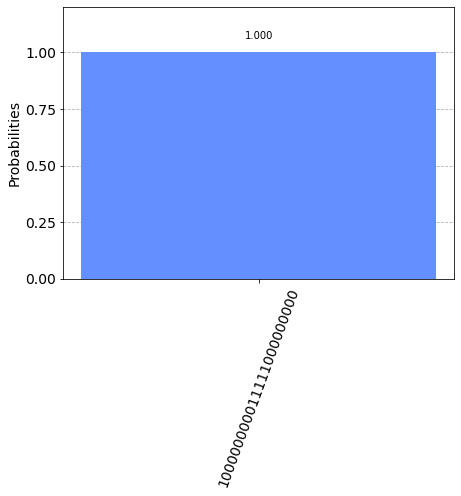

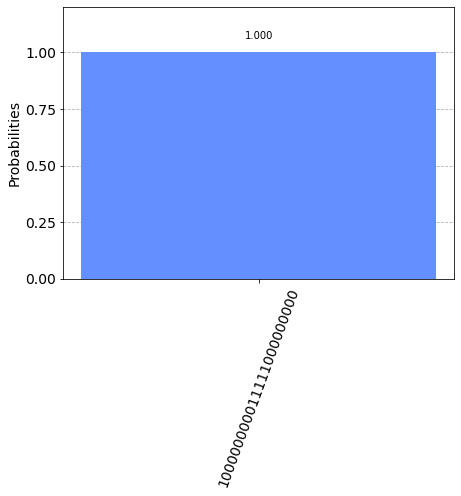

In [48]:
qasm_sim = QasmSimulator(method='statevector')
t_qc = transpile(u_exp_test, qasm_sim)
qobj = assemble(t_qc)
job = qasm_sim.run(qobj)
status = job.status()
print(status)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

In [128]:
a = QuantumRegister(4,'a')
b = QuantumRegister(5,'b')
N = QuantumRegister(4,'n_N')
x = QuantumRegister(5,'n_x')
t = QuantumRegister(1,'t')
control = QuantumRegister(1,'control')
carr = QuantumRegister(4,'carry_g')
output = ClassicalRegister(24,'output')
# exponential_mod(a,b,N,x,carry_g,t,exp,a_value,N_value)
u_exp_test = QuantumCircuit(a,b,N,x,carr,t,control,output)

a_value = 7
N_value = 10
u_exp = 3

# u_exp_test.x(9)
u_exp_test.x(10)
# u_exp_test.x(11)
u_exp_test.x(12)

u_exp_test.x(13)
# u_exp_test.x(14)
# u_exp_test.x(15)


u_exp_test.x(23)


u_exp_test.append(U_exp_mod_eff(a,b,N,x,carr,t,control,a_value,N_value,u_exp), 
                 [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23])

# u_exp_test.draw()

In [129]:
for i in range(24):
    u_exp_test.measure(i,i)

# test_full_adder.measure(7, 3)
u_exp_test.draw()

┌───────┐┌─┐                                                   »
      a_0: ─────┤0      ├┤M├───────────────────────────────────────────────────»
                │       │└╥┘┌─┐                                                »
      a_1: ─────┤1      ├─╫─┤M├────────────────────────────────────────────────»
                │       │ ║ └╥┘┌─┐                                             »
      a_2: ─────┤2      ├─╫──╫─┤M├─────────────────────────────────────────────»
                │       │ ║  ║ └╥┘┌─┐                                          »
      a_3: ─────┤3      ├─╫──╫──╫─┤M├──────────────────────────────────────────»
                │       │ ║  ║  ║ └╥┘┌─┐                                       »
      b_0: ─────┤4      ├─╫──╫──╫──╫─┤M├───────────────────────────────────────»
                │       │ ║  ║  ║  ║ └╥┘┌─┐                                    »
      b_1: ─────┤5      ├─╫──╫──╫──╫──╫─┤M├────────────────────────────────────»
                │       │ ║  ║  ║  ║  ║ └╥┘┌─┐                                 »
      b_2: ─────┤6      ├─╫──╫──╫──╫──╫──╫─┤M├─────────────────────────────────»
                │       │ ║  ║  ║  ║  ║  ║ └╥┘┌─┐                              »
      b_3: ─────┤7      ├─╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────────────────»
                │       │ ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                           »
      b_4: ─────┤8      ├─╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────────────────»
                │       │ ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                        »
    n_N_0: ─────┤9      ├─╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────────────────»
           ┌───┐│       │ ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                     »
    n_N_1: ┤ X ├┤10     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────────────────»
           └───┘│       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐                  »
    n_N_2: ─────┤11     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────────────────»
           ┌───┐│   u_3 │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐               »
    n_N_3: ┤ X ├┤12     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───────────────»
           ├───┤│       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐            »
    n_x_0: ┤ X ├┤13     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├────────────»
           └───┘│       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐         »
    n_x_1: ─────┤14     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├─────────»
                │       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐      »
    n_x_2: ─────┤15     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├──────»
                │       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐   »
    n_x_3: ─────┤16     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├───»
                │       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘┌─┐»
    n_x_4: ─────┤17     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─┤M├»
                │       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ └╥┘»
carry_g_0: ─────┤18     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
                │       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
carry_g_1: ─────┤19     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
                │       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
carry_g_2: ─────┤20     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
                │       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
carry_g_3: ─────┤21     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
                │       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
      t_0: ─────┤22     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
           ┌───┐│       │ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
control_0: ┤ X ├┤23     ├─╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫──╫─»
           └───┘└───────┘ ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║  ║ »
output: 24/═══════════════╩══╩══╩══╩══╩══╩══╩══

JobStatus.INITIALIZING


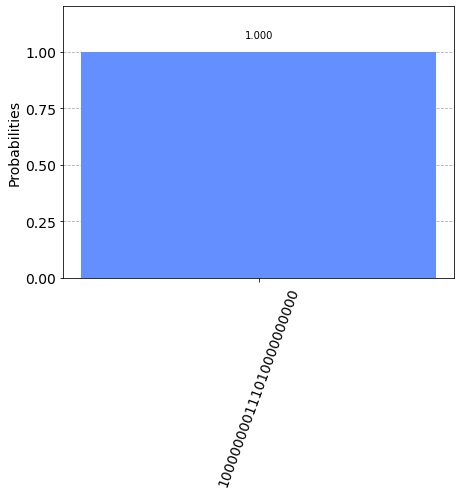

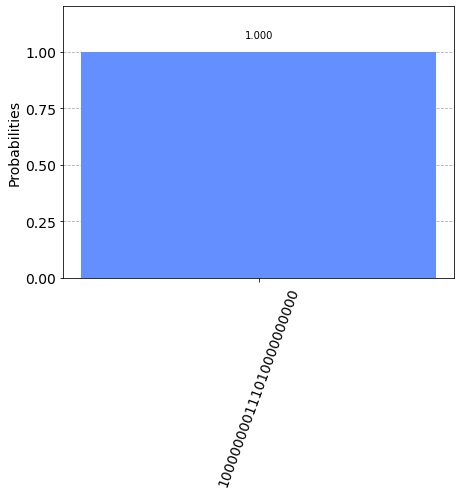

In [130]:
qasm_sim = QasmSimulator(method='statevector')
t_qc = transpile(u_exp_test, qasm_sim)
qobj = assemble(t_qc)
job = qasm_sim.run(qobj)
status = job.status()
print(status)
results = job.result()
counts = results.get_counts()
plot_histogram(counts)

In [131]:
q = QuantumRegister(8,'q')
a = QuantumRegister(4,'a')
b = QuantumRegister(5,'b')
N = QuantumRegister(4,'n_N')
x = QuantumRegister(5,'n_x')
t = QuantumRegister(1,'t')
carr = QuantumRegister(4,'carry_g')
output = ClassicalRegister(8,'output')
# exponential_mod(a,b,N,x,carry_g,t,exp,a_value,N_value)
shor_test = QuantumCircuit(q,a,b,N,x,carr,t,output)

a_value = 7
N_value = 15

shor_test.x(x[0])
shor_test.x(N[0])
shor_test.x(N[1])
shor_test.x(N[2])
shor_test.x(N[3])

for i in range(len(q)):
    shor_test.h(q[i])

for i in range(len(q)):
    print(i)
    shor_test.append(U_exp_mod_eff(a,b,N,x,carr,t,QuantumRegister(1,'aux_control'),a_value,N_value,2**i), 
                     [a[i] for i in range(len(a))] +
                     [b[i] for i in range(len(b))] +
                     [N[i] for i in range(len(N))] +
                     [x[i] for i in range(len(x))] +
                     [carr[i] for i in range(len(carr))] +
                     [t[0]] + 
                     [q[len(q)-1-i]])
shor_test = build_inv_qft_circuit_2(shor_test, 8)


0
1
2
3
4
5
6
7


In [132]:
for i in range(8):
    shor_test.measure(i,i)

# test_full_adder.measure(7, 3)
shor_test.draw()

┌───┐                                                        »
      q_0: ┤ H ├────────────────────────────────────────────────────────»
           ├───┤                                                        »
      q_1: ┤ H ├────────────────────────────────────────────────────────»
           ├───┤                                              ┌────────┐»
      q_2: ┤ H ├──────────────────────────────────────────────┤23      ├»
           ├───┤                                    ┌────────┐│        │»
      q_3: ┤ H ├────────────────────────────────────┤23      ├┤        ├»
           ├───┤                           ┌───────┐│        ││        │»
      q_4: ┤ H ├───────────────────────────┤23     ├┤        ├┤        ├»
           ├───┤                  ┌───────┐│       ││        ││        │»
      q_5: ┤ H ├──────────────────┤23     ├┤       ├┤        ├┤        ├»
           ├───┤         ┌───────┐│       ││       ││        ││        │»
      q_6: ┤ H ├─────────┤23     ├┤       ├┤       ├┤        ├┤        ├»
           ├───┤┌───────┐│       ││       ││       ││        ││        │»
      q_7: ┤ H ├┤23     ├┤       ├┤       ├┤       ├┤        ├┤        ├»
           └───┘│       ││       ││       ││       ││        ││        │»
      a_0: ─────┤0      ├┤0      ├┤0      ├┤0      ├┤0       ├┤0       ├»
                │       ││       ││       ││       ││        ││        │»
      a_1: ─────┤1      ├┤1      ├┤1      ├┤1      ├┤1       ├┤1       ├»
                │       ││       ││       ││       ││        ││        │»
      a_2: ─────┤2      ├┤2      ├┤2      ├┤2      ├┤2       ├┤2       ├»
                │       ││       ││       ││       ││        ││        │»
      a_3: ─────┤3      ├┤3      ├┤3      ├┤3      ├┤3       ├┤3       ├»
                │       ││       ││       ││       ││        ││        │»
      b_0: ─────┤4      ├┤4      ├┤4      ├┤4      ├┤4       ├┤4       ├»
                │       ││       ││       ││       ││        ││        │»
      b_1: ─────┤5      ├┤5      ├┤5      ├┤5      ├┤5       ├┤5       ├»
                │       ││       ││       ││       ││        ││        │»
      b_2: ─────┤6      ├┤6      ├┤6      ├┤6      ├┤6       ├┤6       ├»
                │       ││       ││       ││       ││        ││        │»
      b_3: ─────┤7      ├┤7      ├┤7      ├┤7      ├┤7       ├┤7       ├»
                │       ││       ││       ││       ││        ││        │»
      b_4: ─────┤8      ├┤8      ├┤8      ├┤8      ├┤8       ├┤8  u_32 ├»
           ┌───┐│       ││       ││       ││       ││   u_16 ││        │»
    n_N_0: ┤ X ├┤9      ├┤9      ├┤9      ├┤9  u_8 ├┤9       ├┤9       ├»
           ├───┤│       ││       ││   u_4 ││       ││        ││        │»
    n_N_1: ┤ X ├┤10     ├┤10 u_2 ├┤10     ├┤10     ├┤10      ├┤10      ├»
           ├───┤│   u_1 ││       ││       ││       ││        ││        │»
    n_N_2: ┤ X ├┤11     ├┤11     ├┤11     ├┤11     ├┤11      ├┤11      ├»
           ├───┤│       ││       ││       ││       ││        ││        │»
    n_N_3: ┤ X ├┤12     ├┤12     ├┤12     ├┤12     ├┤12      ├┤12      ├»
           ├───┤│       ││       ││       ││       ││        ││        │»
    n_x_0: ┤ X ├┤13     ├┤13     ├┤13     ├┤13     ├┤13      ├┤13      ├»
           └───┘│       ││       ││       ││       ││        ││        │»
    n_x_1: ─────┤14     ├┤14     ├┤14     ├┤14     ├┤14      ├┤14      ├»
                │       ││       ││       ││       ││        ││        │»
    n_x_2: ─────┤15     ├┤15     ├┤15     ├┤15     ├┤15      ├┤15      ├»
                │       ││       ││       ││       ││        ││        │»
    n_x_3: ─────┤16     ├┤16     ├┤16     ├┤16     ├┤16      ├┤16      ├»
                │       ││       ││       ││       ││        ││        │»
    n_x_4: ─────┤17     ├┤17     ├┤17     ├┤17     ├┤17      ├┤17      ├»
                │       ││       ││       ││       ││        ││        │»
carry_g_0: ─────┤18     ├┤18     ├┤18     ├┤18     ├┤18      ├┤18      ├»
               

In [133]:
qasm_sim = Aer.get_backend('qasm_simulator')
t_qc = transpile(shor_test, qasm_sim)
qobj = assemble(t_qc)

In [ ]:
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [125]:
phase = []
for output in counts:
    decimal = int(output, 2)
    phase.append(float(decimal)/float(2**8))
    print(float(decimal)/float(2**8))

from fractions import Fraction
import math 

r = []
for i in range(len(phase)):
    frac = Fraction(phase[i])
    r.append(frac.denominator)

results = []
for i in range(len(r)): 
    if(r[i]%2 == 0 and 7**(r[i]/2)%15 != 1 and 7**(r[i]/2)%15 != -1):
        x = int(7**(r[i]/2)%15)
        a = math.gcd(x+1, 15)
        b = math.gcd(x-1, 15)
        results.append([a,b])
print(results)

0.25
0.0
0.5
0.75
[[5, 3], [1, 3], [5, 3]]
